# __Pringles__, _a documentation_, __part 2__

In this self-documented document about pringles, we will show: 
- model metadata
- a more large-scale model
- working with some python libraries to build the model
- run the simulation doing some parameter sweeping
- use pandas, matplotlib and some pringles's helpers to analyze the results

## What model is on the menu?
**Graphs!** This demo will be all about graphs. Graphs seems like a really nice abstraction that can be applied to several systems / phenoma we might want to simulate. 

In this case, it's no a generic graph, because that will be uninteresting to simulate. Out model is called a **Graph based SIR**, SIR standing for **S**uceptible, **I**nfectious and **R**ecovered. That saying, each node in the graph will be an individual which might start intfected or not, according to a parameter we have in our model called *infection_prob*. When a simulation is initiated, the Node will flip a coin, and with will become infected with $P(startsInfected)=valueOf(infection\_prob)$. Once started, we have to possibilities, depending on how the model initiates:

![Authomata like Node description](resources/graph_based_SIR.png "Authomata like Node description")

In the image above, you can se how each parameter of node affects its behaviour.

Also, it's nice to work with some graph generation and analysis library: networkx. We will work with it, and integrate it with pringles.

Let's start by instantiating the Simulator, and saving the *registry* in an easy access variable.

In [1]:
from pringles.simulator import Simulator, Simulation
from pringles.models import Coupled
from pringles.utils import VirtualTime

In [2]:
# Instantiate the simulator, targeting our own CD++ distribution (obviously with the atomics we are about to use compiled and registered in it),
#  and the Atomics directory, from which to extact the __Model Metadata__. A bit more on this below.
simulator = Simulator(cdpp_bin_path="user_models/bin", user_models_dir="user_models/")

# Get the Atomic models registry in an easy accessible variable, such as 'r'. Short and concise right?
r = simulator.get_registry()

Now let's look at something interesting. What does targeting the directory where our model sources are located is worth for?

Pringles uses some structured comments we defined in the source files of each model, to instantiate the classes of them for you.

In [3]:
print("  ".join([dict_item for dict_item in dir(r) if not dict_item.startswith("__")]))

Node1  Node10  Node11  Node12  Node13  Node14  Node15  Node16  Node17  Node18  Node19  Node2  Node20  Node3  Node4  Node5  Node6  Node7  Node8  Node9  SUPPORTED_FILE_EXTENSIONS  _add_atomic_class_as_attribute  _discover_atomics  discovered_atomics  get_by_name  user_models_dir


Those NodeN, with N a number, are our node models. Their classes and ports have been already loaded into the pringles registry.

Below, you'll find a detailed explanation of model metadata.

In [4]:
r.Node5("test").get_port("in4")

## Model Metadata

Let's suppose that you don't know abot this model metadata thingy, and that you only have one atomic model in the simulator called __Queue__.
In that case, for it to be accessible from pringles, you would have to define a class, inheriting from Atomic. Furthermore, you would need to declare by hand each port the model has.

Let's see the __Queue__ example, assuming it just hast two input ports, __job__ and __ready___; and one output port, __jobs_status__ .

```python
from pringles.models import Atomic

class Queue(Atomic):
    def __init__(self, name: str, **model_params: str):
        super().__init__(name, **model_params)
        self.add_output_port("job_status")
        self.add_input_port("job")
        self.add_input_port("ready")
```

In my opinions, it's annoying having to write the whole constructor over and over for each Atomic one has already written in C++. Wouldn't it be nice if __pringles__ could read somehow the C++ model implementation?

That's when __model metadata__ comes handy!

Model metadata is a comment format we defined for you to write over each header file of each Atomic you want for pringles to discover. Let's say (following the prior example) you want the _queue_ to be discovered. In that case, you'd just go to _queue.h_, and somewhere on the file (preferrably over the class definition, just for setting a convention) and add a comment like this one:

```c++
/*
@ModelMetadata
name:   Queue
input_ports: job, ready
output_ports: job_status
*/

class Queue : public Atomic {
    /*
    All you lovely CD++ queue impl.
    */
}
```

Let's analyze the syntax a little more, just to be clear:

```c++
/*
@ModelMetadata
name: Queue                     <- This is the atomic model name, which will become in python the class name you'll instance.
input_ports: job, ready         <- comma-separated-list of input ports names
output_ports: job_status        <- comma-separated-list of output ports names
*/
```

## Building and analyzing the model

Now, back to our model. We are going to work with atomics named **NodeN**, with $1 <= n <= 20$, where NodeN is a vertex with N different input, and output ports. In other words, the *Node5* atomic model has 5 input ports named *in0* to *in4*, and the same for *outM*.

According to the model description above, this changes the way in which the *infection* part of the node's behaviour work. Notice that it's not related to the degree-graph-sense of the node, since by using a Node1 (just one input and output port), we can make a vertex of degree 50.

We will describe to approaches for building the network (graph) of individuals we want to simulate:
- A pure pringles approach
- A NetworkX - Pringles mixup

### Pure pringles

For this approach, we will build a fully-connected-graph. For this, we will use just pringles, and leverage the way in which we built our Node atomics. 

First, we will a build a function for building a $N$ nodes fully-connected top model, also propagating the parameters of both the $P(infection)$, *infection_prob*, and the inter-infections exponential time mean, *exp_lambda*.

Then, we will instantiate a sample model (the parameters should be nonsense), and run a simple simulation.

In [5]:
def build_complete_graph_of_nodes(n, exp_lambda, infection_rate):
    # Instantiate 'n' Node1 atomics. Remember that his ones just have one input port (in0), and one ouput (out0)
    nodes = [r.Node1("node%d" % (i), exp_lambda=exp_lambda, infection_prob=infection_rate) for i in range(n)]
    # This will be our top coupled, called 'top' obviously, and will all the nodes we created above
    graph = Coupled("top", nodes)
    # For each pair of different nodes we created, we will connect their only ports.
    for i in range(0,n):
        for j in range(0,n):
            if i != j:
                graph.add_coupling(nodes[i].get_port("out0"), nodes[j].get_port("in0"))
    return graph

In [131]:
# Now, let's instantiate a sample 5 vertexes SIR model.
sample_five_node_graph = build_complete_graph_of_nodes(5, 2, .5)
# NOTE-INTERNAL: I have to run the cell twice in order for Diagrammer for rendering the HTML-representation. Also, sometimes is rendered horribly.
# Notice that we binded Jupyter's rich display environment with our Model implementation.
sample_five_node_graph

In [132]:
# We instantiate the Simulation we are about to run. In case you didn't notice, Simulation objects are immutable once instantiated. 
# This helps having one container for the whole simulation you've ran, and will make things be more ordered.

# The simulation will be of our recently-created 5-node top model, and will be ran for 60 seconds. You can check out the other VirtualTime helpers, or use the main constructor.
sample_simulation = Simulation(sample_five_node_graph, VirtualTime.of_minutes(10))
sample_simulation_results = simulator.run_simulation(sample_simulation)

By running the simulation, we obtain a **SimulationResult** object. This contains among other things, a *pandas dataframe*  for each model participating in the simulation, with its parsed logs. **For the moment, just the output and external transitions are recorded.**

This collection of dataframes is accessed as shown below:

In [133]:
# sample_simulation_results.logs_dfs is a Dict[model_name: str, data: pandas.Dataframe]
sample_simulation_results.logs_dfs.keys()

dict_keys(['node4', 'node3', 'node2', 'node1', 'node0', 'top', 'ParallelRoot'])

As a side note, because this model involves non-deterministic behaviour, it's possible you will have to run the simulation several times in order to observe some behaviour. At least with a 5-node model.

In [134]:
non_empty_model_name = None
for model_name in sample_simulation_results.logs_dfs.keys():
    if sample_simulation_results.logs_dfs[model_name].size > 0 \
        and model_name.startswith('node'):
        non_empty_model_name = model_name

sample_simulation_results.logs_dfs[non_empty_model_name]

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:00:879,top(06),in0,1.0,node0(01)
1,0,L,X,00:00:00:910,top(06),in0,1.0,node0(01)
2,0,L,X,00:00:01:369,top(06),in0,1.0,node0(01)
3,0,L,X,00:00:01:800,top(06),in0,1.0,node0(01)
4,0,L,X,00:00:04:079,top(06),in0,1.0,node0(01)
5,0,L,X,00:00:04:343,top(06),in0,1.0,node0(01)


Now that we can access the results of the simulation, lets do a little of dataframe processing. We will abstract all this in some function, so we can later re-use it with the *NetworkX* approach.

First, let's concatenate all node-models dataframes into one, and sort it by the time the transitions occurred at.

In [135]:
import pandas as pd # We will do some dataframe processing
import matplotlib.pyplot as plt # We will build some custom plots, leveraging pringles vtime autoformat

In [136]:
def merge_all_nodes_results(results):
    # Concatenating all nodes external transitions
    nodes_external_transitions = pd.concat([results.logs_dfs[node_id] for node_id in results.logs_dfs.keys() if node_id.startswith("node")])
    # Sort it by Vtime. This is possible since VirtualTime implements all comparison and equality operators in Python
    nodes_external_transitions = nodes_external_transitions.sort_values(by=["time"])
    return nodes_external_transitions

nodes_external_transitions = merge_all_nodes_results(sample_simulation_results)
nodes_external_transitions

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:00:879,top(06),in0,1.0,node4(05)
0,0,L,X,00:00:00:879,top(06),in0,1.0,node0(01)
0,0,L,X,00:00:00:879,top(06),in0,1.0,node1(02)
0,0,L,X,00:00:00:879,top(06),in0,1.0,node3(04)
1,0,L,X,00:00:00:910,top(06),in0,1.0,node0(01)
1,0,L,X,00:00:00:910,top(06),in0,1.0,node3(04)
0,0,L,X,00:00:00:910,top(06),in0,1.0,node2(03)
1,0,L,X,00:00:00:910,top(06),in0,1.0,node4(05)
2,0,L,X,00:00:01:369,top(06),in0,1.0,node3(04)
1,0,L,X,00:00:01:369,top(06),in0,1.0,node2(03)


Let's analyze some simple behaviour of the model, for example, the accumulated distribution of infections over time. 
We know that an external transition of a *HEALTHY* node occurs when an infected one sends a message to the former one.

Let's drop all unused data in the dataframe, and calculate how many infection get accumulated over time.

In [137]:
def calculate_accumulated_infections(nodes_external_transitions):
    # Count the quantity of external transition over time
    infections_count = nodes_external_transitions.groupby("time").count()
    # Drop all unused columns of dataframe
    infections_count = infections_count.drop([0, 1, "message_type", "model_origin", "port", "model_dest"], axis=1)
    infections_count = infections_count.rename({"value":"infections_count"}, axis=1)
    
    # Since all infection are separated into buckets by its occurring time, let's accumulate them
    accum_infections = [0] * len(list(infections_count.infections_count))
    for i, c in enumerate(list(infections_count.infections_count)):
        if i == 0:
            accum_infections[i] = c
        else:
            accum_infections[i] = accum_infections[i-1] + c
            
    # Also, let's obtain the time of each accumulation bucket
    times = list(infections_count.index)
    
    return times, accum_infections

infection_times, accum_infections = calculate_accumulated_infections(nodes_external_transitions)

Once we calculated the infection accumulated over time, let's draw a plot of them. 

Since the X-axis we want is time, and we are representing it as VirtualTime, we need some way to map this to matplotlib. Fortunately, pringles come with a custom Matplotlib axes generator, which knows how to automatically render and convert the VirtualTime time repsentations.

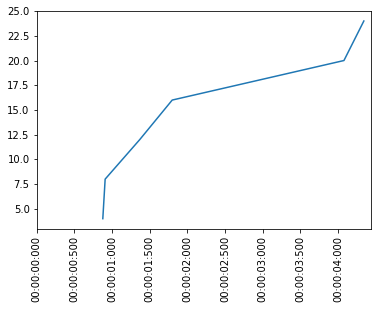

In [138]:
from pringles.utils import new_vtime_aware_axes

def plot_infections_over_time(times, infections):
    # New axes
    ax = new_vtime_aware_axes()
    # Let's set the x-axis limit to the max time we've found, plus a little more.
    ax.set_xlim(0, max([float(vtime) for vtime in times])+float(VirtualTime.from_number(1000)))
    # Plot!
    ax.plot(times, infections)
    ax
    
plot_infections_over_time(infection_times, accum_infections)

TODO: Add restrospective here

### Configuration model graph generation

This second approach consists of leveraging *networkx* random graph generation capabilites, interfacing this with *pringles* to build a model from that graph's description, and simulating the same.

The method used for generating a random graph is called **configuration model**. The explanation of this method is outside the scope of this document, but for reference, lets just quote [wikipedia](https://en.wikipedia.org/wiki/Configuration_model).

For this example, the graph generation code has been hidden inside the *RandomGraphGenerator* class, since this is all the random plus networkx boilerplate. You are encouraged to take a look either way. For this doc sake, the only thing you have to be aware of is that the generated graph is a [NetworkX Graph](https://networkx.github.io/documentation/stable/reference/classes/graph.html).

In [81]:
from generator.graphs import RandomGraphGenerator

random_graph = RandomGraphGenerator(75).generate()
random_graph

Now that we have our graph, using the API exposed by networkx, let's build a coupled model with pringles.

In [82]:
from typing import Dict
import networkx as nx

def build_graph_model_from_nx_graph(graph: nx.Graph, exp_lambda, infection_rate):
    # Fist, for each vertex in the graph, we acquire the degree of that node
    nodes_degrees = [graph.degree(i) for i in range(len(graph.nodes))]
    max_degree = max(nodes_degrees)
    # Just for checking, we fail if some vertex has degree over 20 (our biggest Node atomic has that value)
    if max_degree > 20:
        raise Exception("Do no have models of degree above 20")
    # We create a Node atomic of degree 'd', for each vertex in the graph

    # Notice how we fetch from the registry the Atomic's classes by their name, this is helpful if we want some custom mapping
    # from a any value of type D, to an Atomic class. Obviously in that case, we need to encode that D characteristic inside the 
    # atomic class name.
    nodes = [r.get_by_name("Node%d" % (degree))("node%d" % (i), exp_lambda=exp_lambda, infection_prob=infection_rate) 
             for i, degree in enumerate(nodes_degrees)]

    # Our top model
    pringles_graph = Coupled("top", nodes)
    
    # Some boilerplate code for remembering the last assigned port in each node, so we don't overwrite any of them
    _last_out_node = {}
    _last_in_node = {}
    def do_get_last_port(u: int, dic: Dict[int, int], portname: str):
        if u not in dic:
            dic[u] = 0
            return portname + "0"
        else:
            last = dic[u]
            dic[u] = last+1
            return portname + "%d" % (last+1)
    def last_out_port(u):
        return do_get_last_port(u, _last_out_node, "out")
    def last_in_port(u):
        return do_get_last_port(u, _last_in_node, "in")
    
    # Now, for each edge in the graph, we add a coupling between those two nodes. Here we are using thos 'last_out_port'
    # and 'last_int_port' helpers.
    for u,v in graph.edges():
        pringles_graph.add_coupling(nodes[u].get_port(last_out_port(u)), nodes[v].get_port(last_in_port(v)))
    
    # All done!
    return pringles_graph

Now, we can build a DEVS model from our randomly-generated graph, using the same parameters as the first example. 

In [95]:
random_graph_coupled = build_graph_model_from_nx_graph(random_graph, 2, .6)
random_graph_simulation = Simulation(random_graph_coupled, VirtualTime.of_minutes(10))
random_graph_results = simulator.run_simulation(random_graph_simulation)

In [96]:
# Just checking the captured logs
random_graph_results.logs_dfs.keys()

dict_keys(['node74', 'node73', 'node72', 'node71', 'node70', 'node69', 'node68', 'node67', 'node66', 'node65', 'node64', 'node63', 'node62', 'node61', 'node60', 'node59', 'node58', 'node57', 'node56', 'node55', 'node54', 'node53', 'node52', 'node51', 'node50', 'node49', 'node48', 'node47', 'node46', 'node45', 'node44', 'node43', 'node42', 'node41', 'node40', 'node39', 'node38', 'node37', 'node36', 'node35', 'node34', 'node33', 'node32', 'node31', 'node30', 'node29', 'node28', 'node27', 'node26', 'node25', 'node24', 'node23', 'node22', 'node21', 'node20', 'node19', 'node18', 'node17', 'node16', 'node15', 'node14', 'node13', 'node12', 'node11', 'node10', 'node9', 'node8', 'node7', 'node6', 'node5', 'node4', 'node3', 'node2', 'node1', 'node0', 'top', 'ParallelRoot'])

In [97]:
# And checking one of them that's non emtpy
non_empty_model_name = None
for model_name in random_graph_results.logs_dfs.keys():
    if random_graph_results.logs_dfs[model_name].size > 0 \
        and model_name.startswith('node'):
        non_empty_model_name = model_name

random_graph_results.logs_dfs[non_empty_model_name]

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:01:747,top(76),in5,1.0,node23(24)


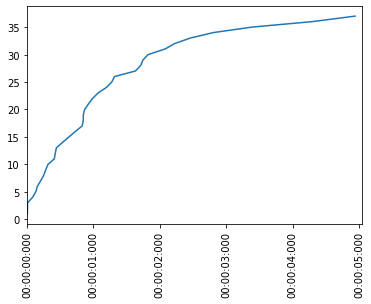

In [108]:
merged_results = merge_all_nodes_results(random_graph_results)
times, infections = calculate_accumulated_infections(merged_results)
plot_infections_over_time(times, infections)